In [1]:
import csv

###Вводные

Решил исследовать dataset anime. Источник: https://github.com/caserec/Datasets-for-Recommender-Systems/tree/master/Processed%20Datasets/Anime

Датасет близок по теме и я могу делать выводы о его качестве по личному опыту. А так же таблица рейтинга зрительXаниме вынесена отдельно и это не нужно будет делать вручную

###Подготовка к EDA и оценкам

Первоначально столкнулся с проблемой обработки жанров, как важного элемента оценки рекоммендаций. Данные были представлены в формате:

| anime_ids | name                          | genre                                             | type  | episodes | rating | members |
|-----------|-------------------------------|---------------------------------------------------|-------|----------|--------|---------|
| 1723      | Kimi no Na wa.                | Drama, Romance, School, Supernatural            | Movie | 1        | 9.37   | 200630  |
| 82        | Fullmetal Alchemist: Brotherhood | Action, Adventure, Drama, Fantasy, Magic, Military, Shounen | TV    | 64       | 9.26   | 793665  |


В таком виде будет сложнее анализировать произведения по жанрам, сравнивать их на разнообразие в конце. Поэтому взял аниме, у которых есть хотя бы один из популярных жанров

In [2]:
def count_filtered_titles(dat_file, target_genres):
    total_titles = 0
    matching_titles = 0

    with open(dat_file, 'r', encoding='utf-8') as file:
        next(file)
        for line in file:
            total_titles += 1
            columns = line.strip().split('\t')
            if len(columns) < 3:
                continue
            genres = columns[2].split(',')
            genres = {g.strip() for g in genres}

            if any(genre in genres for genre in target_genres):
                matching_titles += 1

    return matching_titles


dat_file = 'anime_info.dat'
target_genres = {
    'Comedy', 'Action', 'Sci-Fi', 'Adventure', 'Fantasy', 'Drama', 'Shounen',
    'Romance','Shoujo', 'Seinen'
}

matching_titles = count_filtered_titles(dat_file, target_genres)
print(matching_titles)


6118


Небольшая потеря в сравнении с 7390 изначальными произведениями

Сами жанры переформатировал по принципу One Hot encoder, а так же оставил только нужные колонки:

In [3]:
def process_anime_dataset(input_file, output_file):
    target_genres = {
        'Comedy', 'Action', 'Sci-Fi', 'Adventure', 'Fantasy',
        'Drama', 'Shounen', 'Romance', 'Shoujo', 'Seinen'
    }

    with open(input_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8', newline='') as outfile:

        reader = csv.DictReader(infile, delimiter='\t')
        fieldnames = ['anime_ids','name', 'type', 'episodes', 'rating', 'members'] + list(target_genres)
        writer = csv.DictWriter(outfile, fieldnames=fieldnames, delimiter='\t')
        writer.writeheader()

        for row in reader:
            genres = set(g.strip() for g in row['genre'].split(','))

            if not any(g in genres for g in target_genres):
                continue

            output_row = {
                'anime_ids': row['anime_ids'],
                'name': row['name'],
                'type': row['type'],
                'episodes': row['episodes'],
                'rating': row['rating'],
                'members': row['members']
            }

            for genre in target_genres:
                output_row[genre] = 1 if genre in genres else 0

            writer.writerow(output_row)


input_file = 'anime_info.dat'
output_file = 'filtered_anime.dat'
process_anime_dataset(input_file, output_file)


Данные приняли вид:

| anime_ids | name | type  | episodes | rating | members | Drama | Adventure | Shoujo | Action | Seinen | Sci-Fi | Fantasy | Comedy | Shounen | Romance |
|-----------|--------------|-------|----------|--------|---------|-------|-----------|--------|--------|--------|--------|---------|--------|---------|---------|
| 1723      |Kimi no Na wa.| Movie | 1        | 9.37   | 200630  | 1     | 0         | 0      | 0      | 0      | 0      | 0       | 0      | 0       | 1       |
| 82        |Fullmetal Alchemist: Brotherhood| TV    | 64       | 9.26   | 793665  | 1     | 1         | 0      | 1      | 0      | 0      | 1       | 0      | 1       | 0       |
| 296       |Gintama°| TV    | 51       | 9.25   | 114262  | 0     | 0         | 0      | 1      | 0      | 1      | 0       | 1      | 1       | 0       |


В связи с удалением некоторых фильмов нужно было зачистить связанные отзывы

In [4]:
import csv

def extract_anime_ids(filtered_anime_file):
    anime_ids = set()
    with open(filtered_anime_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file, delimiter='\t')
        for row in reader:
            anime_ids.add(row['anime_ids'])
    return anime_ids

def filter_ratings(rating_file, output_file, anime_ids):
    with open(rating_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8', newline='') as outfile:

        reader = csv.DictReader(infile, delimiter='\t')
        writer = csv.DictWriter(outfile, fieldnames=reader.fieldnames, delimiter='\t')
        writer.writeheader()

        for row in reader:
            if row['Anime_ID'] in anime_ids:
                writer.writerow(row)


filtered_anime_file = 'filtered_anime.dat'
rating_file = 'anime_ratings.dat'
output_file = 'filtered_ratings.dat'

anime_ids = extract_anime_ids(filtered_anime_file)
filter_ratings(rating_file, output_file, anime_ids)

В итоге осталось 400К из изначальных 500К, более чем достаточно для наших целей

###EDA и визуализации

Имеем две таблицы:

filtered_anime
| anime_ids | name | type  | episodes | rating | members | Drama | Adventure | Shoujo | Action | Seinen | Sci-Fi | Fantasy | Comedy | Shounen | Romance |
|-----------|--------------|-------|----------|--------|---------|-------|-----------|--------|--------|--------|--------|---------|--------|---------|---------|
| 1723      |Kimi no Na wa.| Movie | 1        | 9.37   | 200630  | 1     | 0         | 0      | 0      | 0      | 0      | 0       | 0      | 0       | 1       |
| 82        |Fullmetal Alchemist: Brotherhood| TV    | 64       | 9.26   | 793665  | 1     | 1         | 0      | 1      | 0      | 0      | 1       | 0      | 1       | 0       |
| 296       |Gintama°| TV    | 51       | 9.25   | 114262  | 0     | 0         | 0      | 1      | 0      | 1      | 0       | 1      | 1       | 0       |

members - кол-во просмотревших, далее идут жанры

filtered_ratings
| User_ID | Anime_ID | Feedback  |
|---------|----------|-----------|
|1|	1|	8|
|1|	3|	5|
|1|	5|	9|

Feedback - одна оценка одним пользователем одного аниме

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ratings_df = pd.read_csv('filtered_ratings.dat', sep='\t')

anime_df = pd.read_csv('filtered_anime.dat', sep='\t')


Рейтинг

In [6]:
mean_rating = ratings_df['Feedback'].mean()
median_rating = ratings_df['Feedback'].median()

print(f"Средний рейтинг: {mean_rating:.2f}")
print(f"Медианный рейтинг: {median_rating:.2f}")

reviews_per_anime = ratings_df.groupby('Anime_ID').size()
mean_reviews_per_anime = reviews_per_anime.mean()
median_reviews_per_anime = reviews_per_anime.median()

print(f"Среднее количество отзывов на фильм: {mean_reviews_per_anime:.2f}")
print(f"Медианное количество отзывов на фильм: {median_reviews_per_anime:.2f}")

reviews_per_user = ratings_df.groupby('User_ID').size()
mean_reviews_per_user = reviews_per_user.mean()
median_reviews_per_user = reviews_per_user.median()

print(f"Среднее количество отзывов на пользователя: {mean_reviews_per_user:.2f}")
print(f"Медианное количество отзывов на пользователя: {median_reviews_per_user:.2f}")


Средний рейтинг: 7.81
Медианный рейтинг: 8.00
Среднее количество отзывов на фильм: 67.35
Медианное количество отзывов на фильм: 15.00
Среднее количество отзывов на пользователя: 85.32
Медианное количество отзывов на пользователя: 43.00


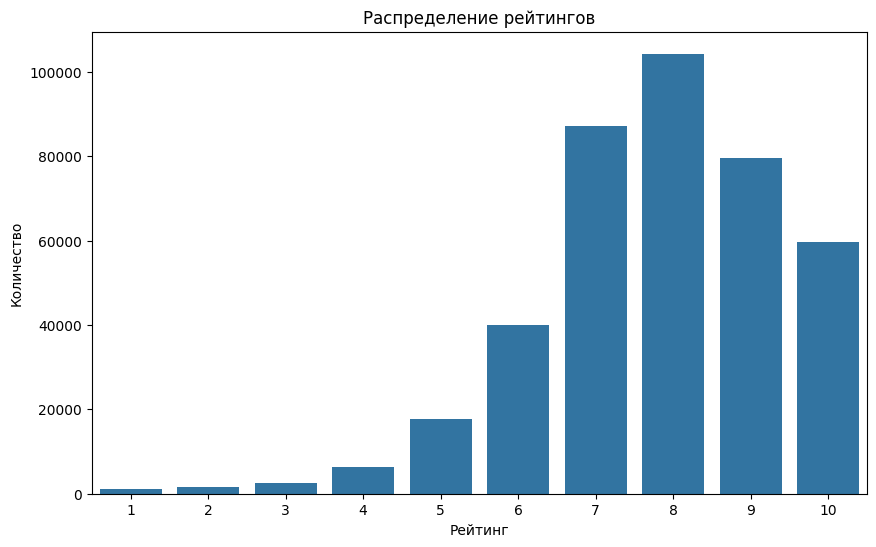

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Feedback', data=ratings_df)
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.show()


In [8]:
reviews_count = ratings_df['Anime_ID'].value_counts().reset_index()
reviews_count.columns = ['anime_id', 'review_count']

anime_with_reviews = pd.merge(anime_df, reviews_count, left_on='anime_ids', right_on='anime_id', how='left')
anime_with_reviews['review_count'] = anime_with_reviews['review_count'].fillna(0)

bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']
anime_with_reviews['rating_bin'] = pd.cut(anime_with_reviews['rating'], bins=bins, labels=labels, include_lowest=True)


In [9]:
low_reviews_anime = anime_with_reviews[anime_with_reviews['review_count'] < 5]

total_in_bin = anime_with_reviews['rating_bin'].value_counts().sort_index()
low_reviews_in_bin = low_reviews_anime['rating_bin'].value_counts().sort_index()

percentage_low_reviews = (low_reviews_in_bin / total_in_bin) * 100
percentage_low_reviews = percentage_low_reviews.fillna(0)

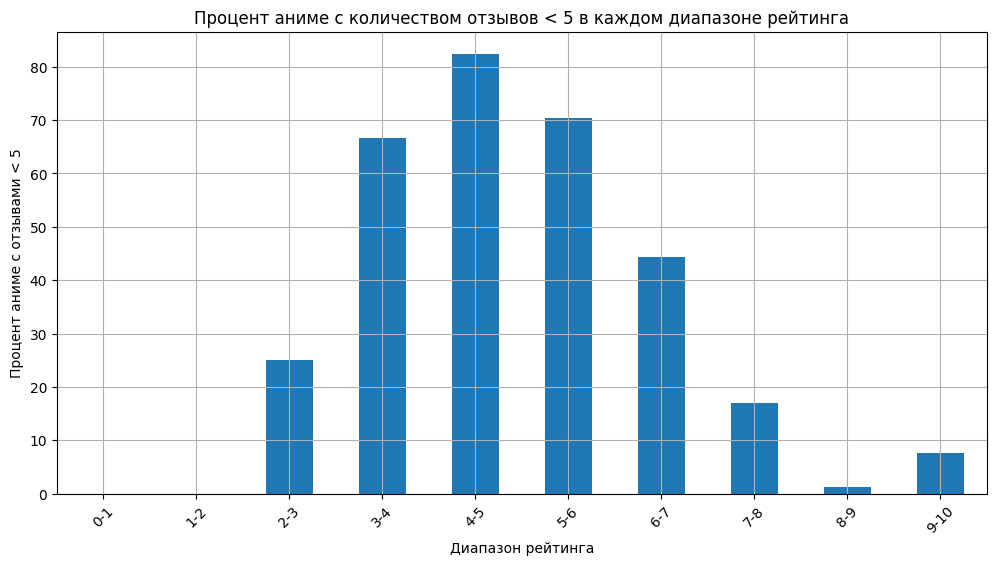

In [10]:
plt.figure(figsize=(12, 6))
percentage_low_reviews.plot(kind='bar')
plt.title('Процент аниме с количеством отзывов < 5 в каждом диапазоне рейтинга')
plt.xlabel('Диапазон рейтинга')
plt.ylabel('Процент аниме с отзывами < 5')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Как и ожидалось: плохие оценки -> мало просмотров -> мало отзывов

Поводов проводить очистку нет, тк в произведениях с хорошими оценками >=7 всё относительно неплохо и данные будут релевантными

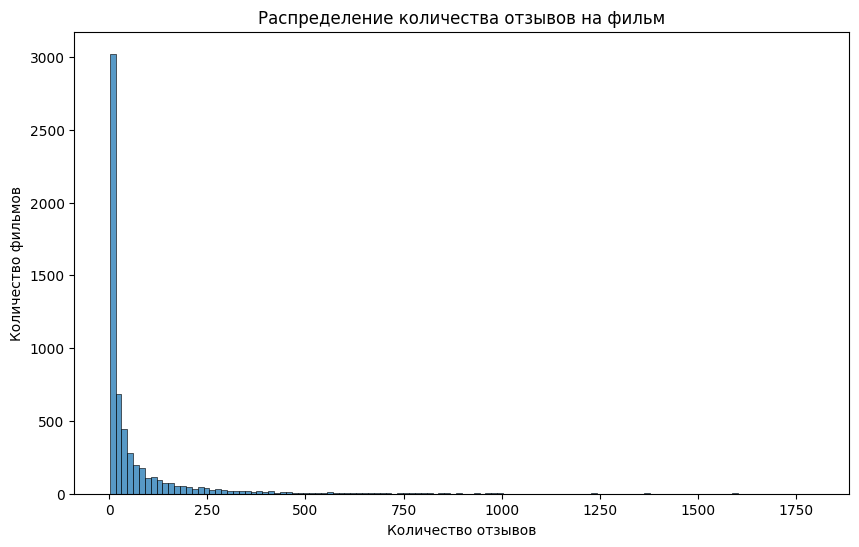

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(reviews_per_anime, bins=120)
plt.title('Распределение количества отзывов на фильм')
plt.xlabel('Количество отзывов')
plt.ylabel('Количество фильмов')
plt.show()

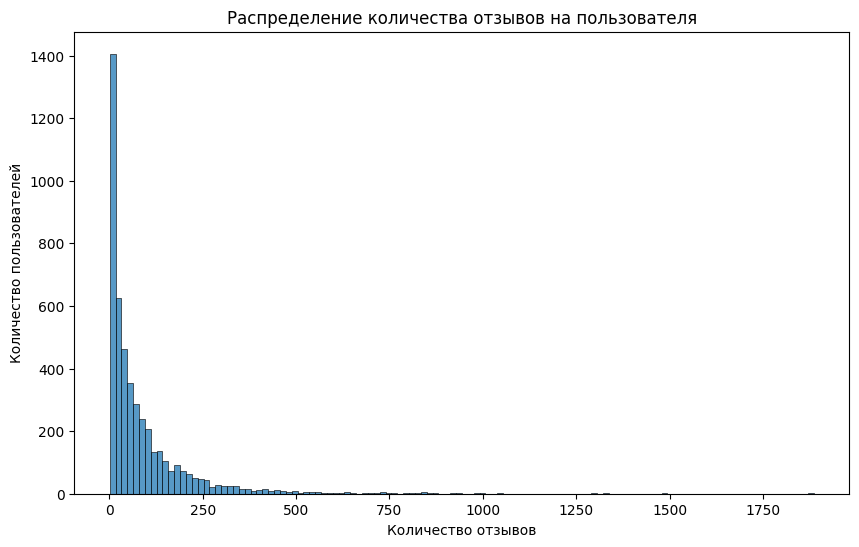

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(reviews_per_user, bins=120)
plt.title('Распределение количества отзывов на пользователя')
plt.xlabel('Количество отзывов')
plt.ylabel('Количество пользователей')
plt.show()

Интерпретация:

Мало низих рейтингов, в среднем произведения высоко оцениваются

Много фильмов с малым кол-вом отзывов

Чуть меньше пользователей с малым кол-вом отзывов

Аниме

In [13]:
mean_episodes = anime_df['episodes'].mean()
median_episodes = anime_df['episodes'].median()

print(f"Среднее количество эпизодов: {mean_episodes:.2f}")
print(f"Медианное количество эпизодов: {median_episodes:.2f}")

type_counts = anime_df['type'].value_counts()
print("\nКоличество каждого типа:")
print(type_counts)

mean_rating_anime = anime_df['rating'].mean()
median_rating_anime = anime_df['rating'].median()

print(f"\nСредний рейтинг аниме: {mean_rating_anime:.2f}")
print(f"Медианный рейтинг аниме: {median_rating_anime:.2f}")

genre_columns = ['Drama', 'Adventure', 'Shoujo', 'Action', 'Seinen', 'Sci-Fi', 'Fantasy', 'Comedy', 'Shounen', 'Romance']
genre_counts = anime_df[genre_columns].sum().sort_values(ascending=False)
print("\nКоличество каждого жанра:")
print(genre_counts)


Среднее количество эпизодов: 13.21
Медианное количество эпизодов: 4.00

Количество каждого типа:
type
TV         2447
OVA        1380
Special    1034
Movie       992
ONA         214
Music        51
Name: count, dtype: int64

Средний рейтинг аниме: 6.98
Медианный рейтинг аниме: 7.02

Количество каждого жанра:
Comedy       3033
Action       2100
Sci-Fi       1547
Adventure    1536
Fantasy      1467
Drama        1402
Shounen      1350
Romance      1259
Shoujo        432
Seinen        419
dtype: int64


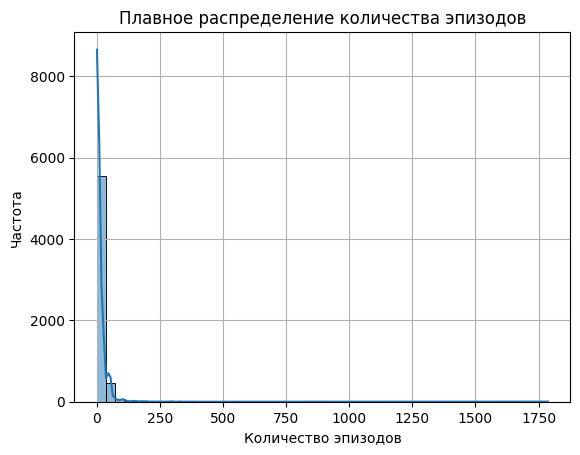

In [14]:
sns.histplot(anime_df['episodes'], bins=50, kde=True)
plt.title('Плавное распределение количества эпизодов')
plt.xlabel('Количество эпизодов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Подчистим редкие произведения с более чем 60 эпизодами

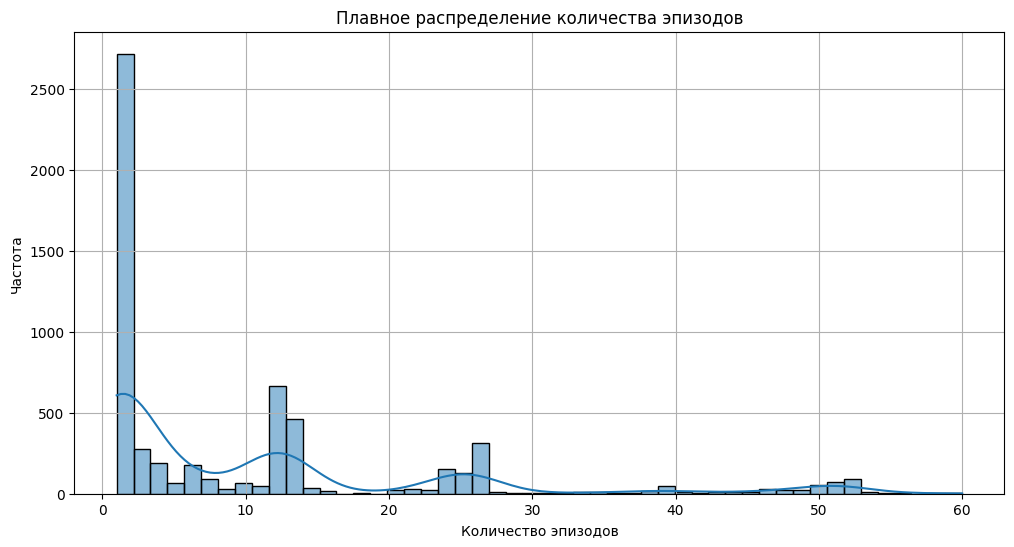

In [15]:
filtered_anime_df = anime_df[anime_df['episodes'] <= 60]
plt.figure(figsize=(12, 6))
sns.histplot(filtered_anime_df['episodes'], bins=50, kde=True)
plt.title('Плавное распределение количества эпизодов')
plt.xlabel('Количество эпизодов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

По опыту у произведения обычно либо 3 или меньше крупнометражных части, либо сезон до 13 эпизодов, либо сезон до 26 эпизодов. Видим отражение этого на графике

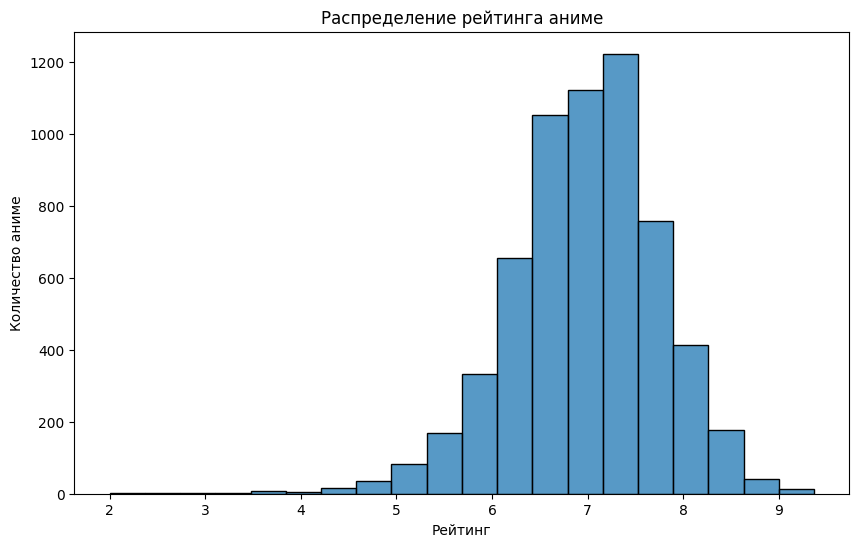

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(anime_df['rating'], bins=20)
plt.title('Распределение рейтинга аниме')
plt.xlabel('Рейтинг')
plt.ylabel('Количество аниме')
plt.show()

Видим отражение ранее замеченного распределения рейтигов, тонкие плечи, высокое тело распределения

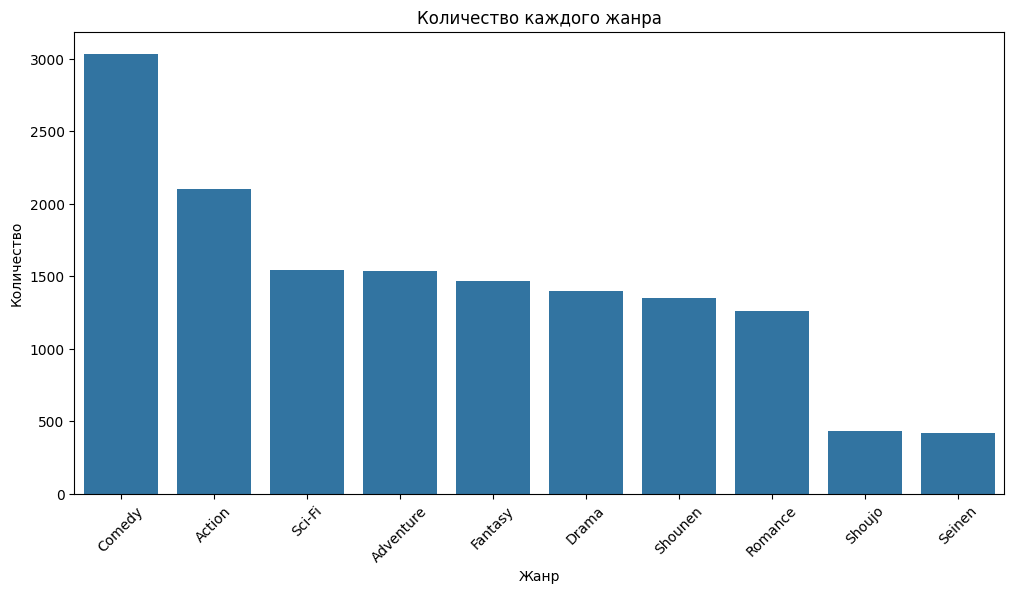

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Количество каждого жанра')
plt.xlabel('Жанр')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Мало аниме с жанрами Shoujo и Seinen, но их важно оставить, тк это метки аниме для девушек юного возраста и взрослых(20 и более лет) зрителей

Качество данных

In [18]:
print("Пропуски в данных о рейтингах:")
print(ratings_df.isnull().sum())

print("\nПропуски в данных об аниме:")
print(anime_df.isnull().sum())


Пропуски в данных о рейтингах:
User_ID     0
Anime_ID    0
Feedback    0
dtype: int64

Пропуски в данных об аниме:
anime_ids    0
name         0
type         0
episodes     0
rating       0
members      0
Sci-Fi       0
Seinen       0
Shounen      0
Romance      0
Adventure    0
Shoujo       0
Drama        0
Fantasy      0
Comedy       0
Action       0
dtype: int64


In [19]:
duplicate_ratings = ratings_df.duplicated().sum()
print(f"\nКоличество дубликатов в данных о рейтингах: {duplicate_ratings}")

duplicate_anime = anime_df.duplicated(subset='anime_ids').sum()
print(f"Количество дубликатов в данных об аниме: {duplicate_anime}")



Количество дубликатов в данных о рейтингах: 0
Количество дубликатов в данных об аниме: 0


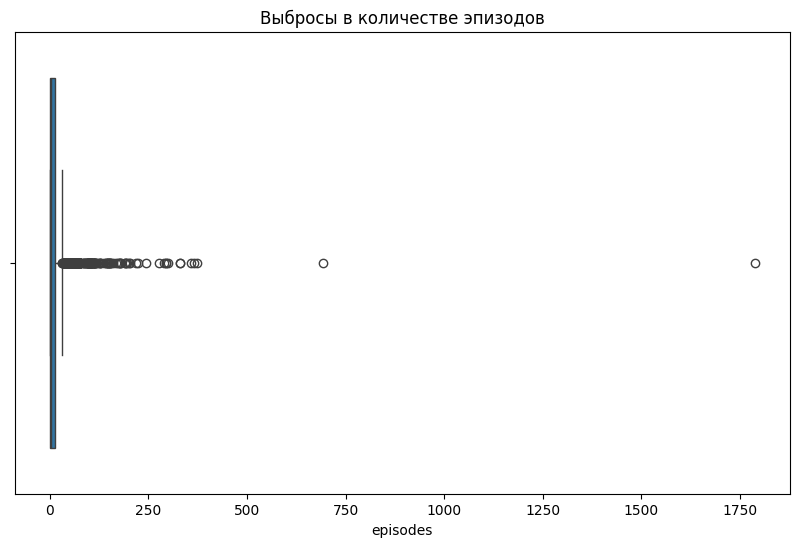

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=anime_df['episodes'])
plt.title('Выбросы в количестве эпизодов')
plt.show()

Вспоминаем наше исключение для произведений с более чем 60 эпизодами

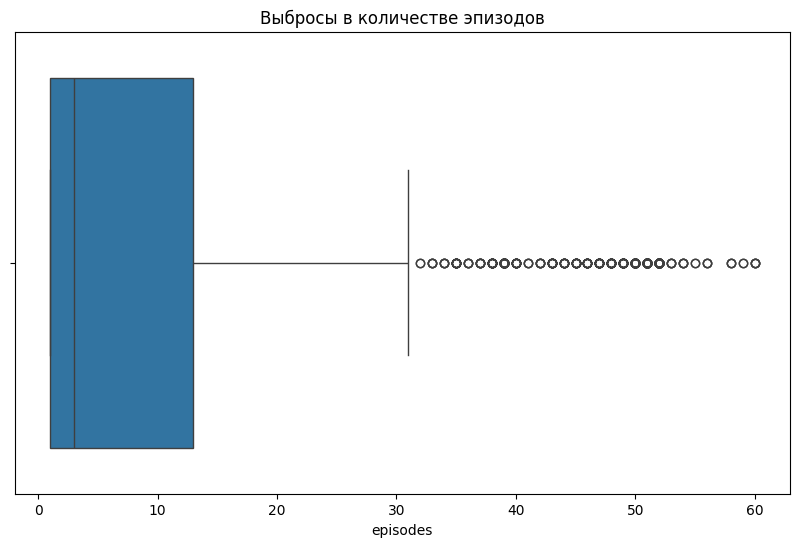

In [21]:
filtered_anime_df = anime_df[anime_df['episodes'] <= 60]
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_anime_df['episodes'])
plt.title('Выбросы в количестве эпизодов')
plt.show()

Учитывая полученное ранее респределение, я бы оставил датасет с кол-вом эпизодов <=60, хоть и придётся исключить 2-3 культовых произведения:

Doraemon (1969-1996) детский сериал на 1787 серий

Ninja Hattori-kun (1964-1968) детский сериал на ~700 серий

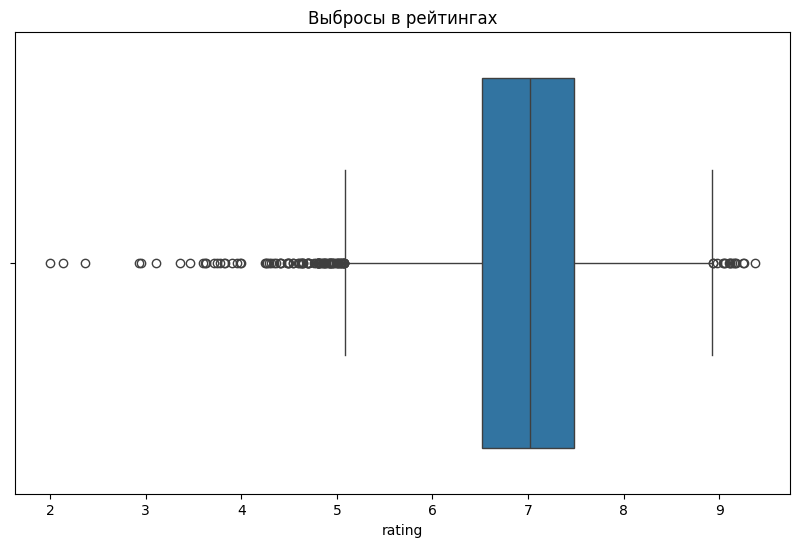

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=anime_df['rating'])
plt.title('Выбросы в рейтингах')
plt.show()

В итоге видим, что пропусков и дублей в датасете нет, только исключаем произведения с более чем 60 эпизодами

###Предобработка данных

In [23]:
anime_df = anime_df[anime_df['episodes'] <= 60]

####Рекомендации

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import scipy.sparse as sps


ratings = pd.read_csv("filtered_ratings.dat", sep=r"\t", engine='python')
animes = pd.read_csv("filtered_anime.dat", sep=r"\t", engine='python')

ratings.columns = ["user_id", "anime_id", "rating"]
animes.columns = ["anime_id", "name", "type", "episodes", "rating", "members",
                  "Fantasy", "Shounen", "Action", "Comedy", "Adventure",
                  "Shoujo", "Seinen", "Drama", "Romance", "Sci-Fi"]



In [25]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

user_item = train.pivot(index='user_id', columns='anime_id', values='rating').fillna(0)
user_item_matrix = user_item.values

user_ids = user_item.index.tolist()
item_ids = user_item.columns.tolist()
print(len(item_ids))
print(len(user_ids))
user_to_idx = {u: i for i, u in enumerate(user_ids)}
item_to_idx = {a: i for i, a in enumerate(item_ids)}

5766
4642


###MostPop

In [44]:
sorted_animes = animes.sort_values(by="members", ascending=False)

def recommend_mostpop(user_id, n=5):
    top_anime_ids = sorted_animes.head(n)['anime_id'].tolist()
    return top_anime_ids

###UserKNN

In [27]:
def build_user_similarity(matrix):
    sim = cosine_similarity(matrix)
    np.fill_diagonal(sim, 0)
    return sim

In [28]:
user_similarity = build_user_similarity(user_item_matrix)


In [29]:
def recommend_userknn(user_id, k=100, n=5):
    if user_id not in user_to_idx:
        return recommend_mostpop(user_id, n)
    u_idx = user_to_idx[user_id]

    sim_scores = user_similarity[u_idx]
    top_users = np.argsort(sim_scores)[-k:]

    sim_vals = sim_scores[top_users]
    ratings_subset = user_item_matrix[top_users]
    pred = np.dot(sim_vals, ratings_subset) / (np.sum(np.abs(sim_vals)) + 1e-9)

    rated_items = user_item_matrix[u_idx] > 0
    pred[rated_items] = -np.inf

    rec_idx = np.argsort(pred)[-n:][::-1]
    return [item_ids[i] for i in rec_idx]

###ALS

In [30]:
def als_train(R, n_factors=11, n_iters=50, reg=0.2):
    num_users, num_items = R.shape
    U = np.random.normal(scale=1./n_factors, size=(num_users, n_factors))
    V = np.random.normal(scale=1./n_factors, size=(num_items, n_factors))

    R_csr = sps.csr_matrix(R)

    for it in range(n_iters):
        for u in range(num_users):
            idx = R_csr[u].indices
            if len(idx) == 0:
                continue
            V_i = V[idx]
            r_u = R_csr[u, idx].toarray().flatten()
            A = V_i.T @ V_i + reg * np.eye(n_factors)
            b = V_i.T @ r_u
            U[u] = np.linalg.solve(A, b)

        for i in range(num_items):
            idx = R_csr[:, i].indices
            if len(idx) == 0:
                continue
            U_i = U[idx]
            r_i = R_csr[idx, i].toarray().flatten()
            A = U_i.T @ U_i + reg * np.eye(n_factors)
            b = U_i.T @ r_i
            V[i] = np.linalg.solve(A, b)

    return U, V

U, V = als_train(user_item_matrix, n_factors=11, n_iters=30, reg=0.2)

def recommend_als(user_id, n=5):
    if user_id not in user_to_idx:
        return recommend_mostpop(user_id, n)
    u_idx = user_to_idx[user_id]
    scores = U[u_idx] @ V.T
    rated = user_item_matrix[u_idx] > 0
    scores[rated] = -np.inf
    rec_idx = np.argsort(scores)[-n:][::-1]
    return [item_ids[i] for i in rec_idx]

###Оценка качества

In [31]:
def precision_at_k(pred, actual, k=5):
    pred = pred[:k]
    return len(set(pred) & set(actual)) / k

def recall_at_k(pred, actual, k=5):
    pred = pred[:k]
    return len(set(pred) & set(actual)) / max(len(actual), 1)

def ndcg_at_k(pred, actual, k=5):
    dcg = 0.0
    for i, p in enumerate(pred[:k]):
        if p in actual:
            dcg += 1 / np.log2(i + 2)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(actual), k)))
    return dcg / idcg if idcg > 0 else 0

def diversity(pred_items, item_features):
    if len(pred_items) < 2:
        return 0
    feats = item_features.loc[pred_items].values
    sim = cosine_similarity(feats)
    return 1 - np.mean(sim[np.triu_indices(len(pred_items), 1)])

In [32]:
item_features = animes.set_index("anime_id")[["Sci-Fi","Romance","Action","Seinen","Drama",
                                              "Shounen","Comedy","Shoujo","Fantasy","Adventure"]]

def pass_through_wrapper(preds):
    return preds
def evaluate_model(name, recommend_func, test, k=5, wrapper_func=pass_through_wrapper):
    metrics = {"precision": [], "recall": [], "ndcg": [], "diversity": []}
    for uid in test['user_id'].unique():
        actual = test[test['user_id'] == uid]
        actual = actual[actual['rating'] >=7]['anime_id'].tolist()
        preds = wrapper_func(recommend_func(uid, n=k))
        if len(preds) == 0:
            continue

        metrics["precision"].append(precision_at_k(preds, actual, k))
        metrics["recall"].append(recall_at_k(preds, actual, k))
        metrics["ndcg"].append(ndcg_at_k(preds, actual, k))
        metrics["diversity"].append(diversity(preds, item_features))

    results = {m: np.mean(v) for m, v in metrics.items()}
    print(f"\n=== {name} Model Evaluation ===")
    for m, v in results.items():
        print(f"{m}: {v:.4f}")
    return results


Будем рекомендовать 40(медианное число отзывов на фильм)*0.2(сколько взяли оценок для теста)=8

In [46]:
mostpop_results = evaluate_model("MostPop", recommend_mostpop, test, k=8)


=== MostPop Model Evaluation ===
precision: 0.0666
recall: 0.0620
ndcg: 0.0824
diversity: 0.5907


В среднем вам понравится 1/50 аниме предложенных таким образом. Такой рейтинг мешает все жанры друг с другом, хотя рейтинги обычно формируются внтури них. Возможно, будет работать лучше, если учитывать жанровые предпочтения пользователя

In [45]:
userknn_results = evaluate_model("UserKNN", recommend_userknn, test, k=8)


=== UserKNN Model Evaluation ===
precision: 0.2293
recall: 0.1854
ndcg: 0.3021
diversity: 0.5876


UserKNN ожидаемо показал хороший результат. Вам понравится 1/5 фильмов

Его результат концептуально можно назвать общей рекомендацией людей с похожим вкусом, что уже учитывает множество параметров(лучшие годы сценариста, насколько команда была в форме во время производства и тд). Подобный результат можно повторить лишь имя огромное число параметров

In [38]:
def sort_by_global_rating_wrapper(preds):
    filtered = animes[animes['anime_id'].isin(preds)]
    sorted_items = (
        filtered.sort_values(by='members', ascending=False)['anime_id']
        .tolist()
    )
    return sorted_items
userknn_results = evaluate_model("UserKNN", recommend_userknn, test, k=8, wrapper_func=sort_by_global_rating_wrapper)


=== UserKNN Model Evaluation ===
precision: 0.2293
recall: 0.1854
ndcg: 0.2523
diversity: 0.5876


Попытка улучшить результат, сортируюя его по рейтингу, ухудшила ndcg, что говорит о бесполезности MostPop в таком применении

In [39]:
als_results = evaluate_model("ALS", recommend_als, test, k=8) #11 факторов, 30 итераций, регулировка = 0.2


=== ALS Model Evaluation ===
precision: 0.0273
recall: 0.0211
ndcg: 0.0429
diversity: 0.6598


Результат почти как на MostPop. Практически как у BaseLine - MostPop. Похоже метод плохо улавливает скрытые фичи на данном датасете и у него не получается сделать хорошие предложения

In [40]:
als_results = evaluate_model("ALS", recommend_als, test, k=8, wrapper_func=sort_by_global_rating_wrapper)


=== ALS Model Evaluation ===
precision: 0.0273
recall: 0.0211
ndcg: 0.0505
diversity: 0.6598


Получилось немного улучшить результат(ndcg), отсортировав аниме по рейтингу

Вывод: используем UserKNN. Можно попробовать MostPop c учётом жанровых предпочтений зрителя

Добавим сравнение результатов разных методов

In [41]:
als_results = evaluate_model("ALS", recommend_als, test, k=8)
mostpop_results = evaluate_model("MostPop", recommend_mostpop, test, k=8)
userknn_results = evaluate_model("UserKNN", recommend_userknn, test, k=8)


comparison = pd.DataFrame([als_results, mostpop_results, userknn_results],
                          index=["ALS", "MostPop", "UserKNN"])
print("\n=== Сравнение методов по метрикам ===")
print(comparison)


=== ALS Model Evaluation ===
precision: 0.0273
recall: 0.0211
ndcg: 0.0429
diversity: 0.6598

=== MostPop Model Evaluation ===
precision: 0.0666
recall: 0.0620
ndcg: 0.0824
diversity: 0.5907

=== UserKNN Model Evaluation ===
precision: 0.2293
recall: 0.1854
ndcg: 0.3021
diversity: 0.5876

=== Сравнение методов по метрикам ===
         precision    recall      ndcg  diversity
ALS       0.027276  0.021073  0.042939   0.659776
MostPop   0.066585  0.061969  0.082410   0.590659
UserKNN   0.229350  0.185417  0.302133   0.587587
